In [1]:
from lib import utilities
import numpy as np
import copy
from qiskit.quantum_info import Operator
from qiskit.utils.mitigation.fitters import CompleteMeasFitter
from qiskit.ignis.mitigation.measurement import  complete_meas_cal
from qiskit import Aer, QuantumCircuit, QuantumRegister, IBMQ, execute
from qiskit.providers.aer import QasmSimulator
from qiskit.opflow import Zero, One, I, X, Y, Z
from qiskit.ignis.verification.tomography import state_tomography_circuits
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2
import warnings
warnings.filterwarnings('ignore')
IBMQ.load_account()

provider = IBMQ.get_provider(hub='ibm-q-community',
                            group='ibmquantumawards', 
                            project='open-science-22')
backend_sim_jakarta = QasmSimulator.from_backend(provider.get_backend('ibmq_jakarta'))
backend_real_jakarta = provider.get_backend('ibmq_jakarta')
backend_sim = Aer.get_backend('qasm_simulator')

# Time Evolution Plots

This is a supplemetary notebook which implement the time evolution of our solution.


In [2]:
##################################################### defining parameters
N_STEPS = 99 # trotter steps
N_POINTS = 80 # numper of plot points
TIME_RANGE = np.linspace(0.001, np.pi, N_POINTS) # time range
TIME_CALIBRATION = np.pi/3 # the calibration circuits are built with this time
DECOMPOSITION = "SSD" # "SSD" or "HSD"
INITIAL_STATE = "110" # "110" corrispondent qubits "531". We haven't tested the code for different initial states.
BAKEND = backend_sim_jakarta
SHOTS_EVOLUTIONS = 8192 # each evolution 
SHOTS_CALIBRATIONS = 32000
PLOT_RESULTS_OF = ["raw", "Qiskit", "NIC", "CIC"] # you can choose between: "raw", "Qiskit", "NIC", "CIC"
                                 # with "Qiskit" we intend the measurment mitigation technique implemented by qiskit.

In [3]:
################################################## starting the simulations
if DECOMPOSITION == "HSD":
    NIC_eigenvector = "111" 
elif DECOMPOSITION == "SSD":
     NIC_eigenvector = "000"
############################################################################
############### circuits building
print("building circuits")
# qiskit measure calibration circuits.
qr_cal = QuantumRegister(3)
calib_circuits_qiskit, state_labels = complete_meas_cal(qubit_list=[0,1,2], qr=qr_cal, circlabel='mcal')
# NIC and CIC calibration circuits.
evo_qc_calibration, evo_qr_calibration = utilities.get_evolution_circuit(TIME_CALIBRATION, N_STEPS, method=DECOMPOSITION)

calib_circuits_NIC = utilities.get_calibration_circuits(evo_qc_calibration, method="NIC", eigenvector=NIC_eigenvector)
calib_circuits_CIC = utilities.get_calibration_circuits(evo_qc_calibration, method="CIC")
# evolution tomograhy circuits.
qcs_tomography_list = []
for i, time in enumerate(TIME_RANGE):
    evo_qr = QuantumRegister(3)
    evo_qc = QuantumCircuit(evo_qr)
    evolution, evolution_qr = utilities.get_evolution_circuit(time, N_STEPS, method=DECOMPOSITION)
    evo_qc.x([evo_qr[1],evo_qr[2]])
    evo_qc.append(evolution, evo_qr)
    qcs_tomography = state_tomography_circuits(evo_qc, evo_qr)
    qcs_tomography_list.append(qcs_tomography)

############### execute all
print("execute all circuits")
# calibration circuits. For each techniqe are runned 8 (2^n) calibration circuits.
job_NIC=execute(calib_circuits_NIC, backend = BAKEND, shots=SHOTS_CALIBRATIONS, initial_layout=[1,3,5])
job_CIC=execute(calib_circuits_CIC, backend = BAKEND, shots=SHOTS_CALIBRATIONS, initial_layout=[1,3,5])
job_qiskit=execute(calib_circuits_qiskit, backend = BAKEND, shots=SHOTS_CALIBRATIONS, initial_layout=[1,3,5])

# evolution cicuits. Are runned 27 circuits for each point.
jobs_evo = []
for i in range(N_POINTS):
    job=execute(qcs_tomography_list[i], backend = backend_sim_jakarta, shots=SHOTS_EVOLUTIONS, initial_layout=[1,3,5])
    jobs_evo.append(job)
    if i%10 == 0: print(i)

############### mitigation
print("mitigation")
# compute the U_ideal unitary matrix of the circuit. Is used only for the CIC mitigation.
U_ideal = Operator(evo_qc_calibration)
# fast_tomography_calibration_MeasFitters returns a list of 27 CompleteMeasFitter objects, one for each tomo basis.
meas_fitters_NIC = utilities.fast_tomography_calibration_MeasFitters(job_NIC.result(), method="NIC")
meas_fitters_CIC = utilities.fast_tomography_calibration_MeasFitters(job_CIC.result(), method="CIC", U_ideal=U_ideal)
meas_fitters_qiskit = CompleteMeasFitter(job_qiskit.result(), state_labels=state_labels)
# in meas_fitters_NIC and meas_fitters_CIC there are all the calibration matrices.

raw_result_list = []
qiskit_result_list = []
NIC_result_list = []
CIC_result_list = []

fids_dict = {
    "110": np.zeros([4, N_POINTS]),
    "101": np.zeros([4, N_POINTS]),
    "011": np.zeros([4, N_POINTS])
}

for i in range(N_POINTS):

    raw_result = jobs_evo[i].result()
    qiskit_result = copy.deepcopy(raw_result)
    NIC_result = copy.deepcopy(raw_result)
    CIC_result = copy.deepcopy(raw_result)

    for j in range(27):
        old_counts=raw_result.get_counts(j)
        new_counts_NIC = meas_fitters_NIC[j].filter.apply(old_counts, method="least_squares")
        NIC_result.results[j].data.counts = new_counts_NIC
        
        new_counts_CIC = meas_fitters_CIC[j].filter.apply(old_counts, method="least_squares")
        CIC_result.results[j].data.counts = new_counts_CIC

        new_counts_qiskit = meas_fitters_qiskit.filter.apply(old_counts, method="least_squares")
        qiskit_result.results[j].data.counts = new_counts_qiskit


    for target_state, string_state in ([One^One^Zero, "110"], [One^Zero^One, "101"], [Zero^One^One, "011"]):
        for j, result in enumerate([raw_result, qiskit_result, NIC_result, CIC_result]):
            fids_dict[string_state][j][i] = utilities._fidelity_count(result, qcs_tomography_list[i], target_state.to_matrix())
            
    if i%10 == 0: print(i)
############### results


building circuits
execute all circuits
0
10
20
30
40
50
60
70
mitigation
0
10
20
30
40
50
60
70


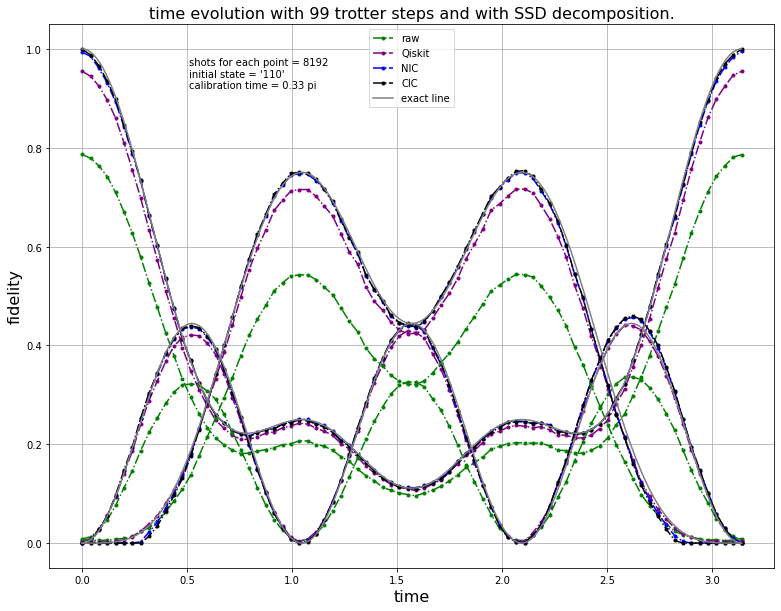

In [14]:
from qiskit.opflow import Zero, One, I, X, Y, Z

def H_heis3():
    # Interactions (I is the identity matrix; X, Y, and Z are Pauli matricies; ^ is a tensor product)
    XXs = (I^X^X) + (X^X^I)
    YYs = (I^Y^Y) + (Y^Y^I)
    ZZs = (I^Z^Z) + (Z^Z^I)
    # Sum interactions
    H = XXs + YYs + ZZs
    # Return Hamiltonian
    return H

def U_heis3(t):
    # Compute XXX Hamiltonian for 3 spins in a line
    H = H_heis3()
    # Return the exponential of -i multipled by time t multipled by the 3 spin XXX Heisenberg Hamilonian 
    return (t * H).exp_i()

def prob_state(time_range, initial_state, target_state):
    return [np.abs((~target_state @ U_heis3(float(t)) @ initial_state).eval())**2 for t in time_range]

t_ideal = np.linspace(0,np.pi, 1000)
ideal_probs = {
    "110": prob_state(t_ideal, One^One^Zero, One^One^Zero),
    "101": prob_state(t_ideal, One^Zero^One, One^One^Zero),
    "011": prob_state(t_ideal, Zero^One^One, One^One^Zero)
}

labels = ["raw", "Qiskit", "NIC", "CIC"]
colors = ["green", "purple", "b", "black"]
result_to_plot_dict = {"raw": 0, "Qiskit": 1,"NIC": 2, "CIC": 3}

plt.figure(figsize=(13,10))
for i, fids in enumerate(fids_dict):
    for to_plot in PLOT_RESULTS_OF:
        j = result_to_plot_dict[to_plot]
        if i == 0: plt.plot(TIME_RANGE, fids_dict[fids][j], linestyle='-.', marker='.', label=labels[j], c=colors[j])
        else: plt.plot(TIME_RANGE, fids_dict[fids][j], linestyle='-.', marker='.', c=colors[j])

for i, state in enumerate(["110", "101", "011"]):
    if i == 0: plt.plot(t_ideal, ideal_probs[state], c="gray", alpha=1, label="exact line")
    else: plt.plot(t_ideal, ideal_probs[state], c="gray", alpha=1)

plt.legend(loc=9)
plt.grid()
plt.xlabel("time", fontsize=16)
plt.ylabel("fidelity", fontsize=16)
plt.title(f"time evolution with {N_STEPS} trotter steps and with {DECOMPOSITION} decomposition.", fontsize=16)
plt.text(0.51, 0.92, "shots for each circuit = %d\ninitial state = '110'\ncalibration time = %.2f pi"%(SHOTS_EVOLUTIONS, TIME_CALIBRATION/np.pi))
plt.savefig(f"evo_time_{DECOMPOSITION}.pdf", format="pdf")
plt.show()